# Data Cleaning and Preprocessing
## Dataset: WEB-IDS23 Dataset
#### Task: Load the csv files one by one do a simple EDA for each.

    Author: Nithusikan T.
    Email: e19266@eng.pdn.ac.lk
    Date: 25/05/2025

#### Import Libraries

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utilities

In [9]:
def load_top_rows_from_csvs(folder_path, n_rows=10000):
    """
    Reads the first `n_rows` from each CSV in the specified folder
    and concatenates them into a single DataFrame.

    Note: It omits the "web-ids23_smtp_enum.csv" file as it contains only 7 rows.
    
    Parameters:
        folder_path (str): Path to the folder containing CSV files.
        n_rows (int): Number of rows to read from each file.

    Returns:
        pd.DataFrame: Combined DataFrame from all CSVs.
    """
    all_dfs = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv") and filename not in ["web-ids23_smtp_enum.csv", "ssh_login.csv", "ssh_login_successful.csv"]:
            file_path = os.path.join(folder_path, filename)
            try:
                df = pd.read_csv(file_path, nrows=n_rows)
                all_dfs.append(df)
                print(f"{filename} loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
            except Exception as e:
                print(f"Could not read {filename}: {e}")
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    return combined_df

def preprocess_data(df, columns_2_drop, target_columns=['attack_type', 'attack']):
    """
    Preprocess the DataFrame by handling missing values, encoding categorical variables,
    and scaling numerical features.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    target_column (str): Name of the target variable column.
    columns_2_drop (list): List of columns to drop from the DataFrame.

    Returns:
    X (pd.DataFrame): Features DataFrame.
    y_1 (pd.Series): Target variable Series.
    y_2 (pd.Series): Second target variable Series.
    """
    # Handle missing values
    df = df.dropna(axis=0, how='any')  # Drop rows with any missing values

    # Separate features and target variable
    X = df.drop(columns=target_columns)
    y_1 = df[target_columns[0]]  # attack_type
    y_2 = df[target_columns[1]]  # attack

    # Drop some columns that are not needed for analysis
    print(f"Dropping columns: {columns_2_drop.tolist()}") # df.columns[0:4])
    X = X.drop(columns=columns_2_drop)

    # Encode categorical variables if any
    X = pd.get_dummies(X, drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return pd.DataFrame(X_scaled, columns=X.columns), pd.Series(y_1), pd.Series(y_2)

def visualize_covariance_matrix(X, color="Blues"):
    """
    Visualize the covariance matrix of the features in the DataFrame.

    Parameters:
    X (pd.DataFrame): Features DataFrame.
    color (str): Color map for the heatmap.

    Returns:
    None
    """
    # plt.figure(figsize=(15, 15))
    covariance_matrix = X.cov()
    # sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap=color)
    # plt.title("Covariance Matrix")
    # # plt.show()

    return covariance_matrix


def train_and_evaluate_model(X, y, color="Blues",top_features=None, classifiers=None):
    """
    Train and evaluate multiple classifiers on the given dataset.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    top_features (list, optional): List of top features to select. If None, all features are used.

    Returns:
    None
    """

    # Select top features if provided
    if top_features is None:
        top_features = X.columns.tolist()  # Use all features if no specific ones are provided
    X_selected = X[top_features]

    # Test train split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    trained_clfs = {}
    performance_dict = {}

    # Train and evaluate each classifier
    for name, clf in classifiers.items():
        print(f"Training {name}...")
        clf.fit(X_train, y_train)
        classifiers[name] = clf
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Print classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_pred))

        # Store the perormance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        performance_dict[name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        }

        # Print classification report
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap=color,
                    xticklabels=clf.classes_, yticklabels=clf.classes_)
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return trained_clfs, performance_dict

def visualize_feature_importances(X, classifier):
    """
    Visualize feature importances for a given classifier.
    Parameters:
    X (pd.DataFrame): Features.
    classifier: The trained classifier with feature importances.
    Returns:
    None
    """
    # Visualize the feature importances for Random Forest
    plt.figure(figsize=(12, 8))
    importances = classifier.feature_importances_
    indices = importances.argsort()[::-1]
    plt.title(f"Feature Importances - {classifier.__class__.__name__}")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

def print_low_performance_classes(report, threshold=0.7):
    """
    Print classes with precision, recall, and f1-score below a specified threshold.

    Parameters:
    report (dict): Classification report from sklearn.
    threshold (float): Threshold for filtering classes.

    Returns:
    None
    """
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            precision = metrics.get('precision', 0)
            recall = metrics.get('recall', 0)
            f1_score = metrics.get('f1-score', 0)
            if precision < threshold or recall < threshold or f1_score < threshold:
                print(f"Class: {class_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")


### Load top set of data from each attack data files

In [11]:
df_balanced = load_top_rows_from_csvs("web-ids23")

web-ids23_benign.csv loaded with 10000 rows and 38 columns.
web-ids23_bruteforce_http.csv loaded with 10000 rows and 38 columns.
web-ids23_bruteforce_https.csv loaded with 10000 rows and 38 columns.
web-ids23_dos_http.csv loaded with 10000 rows and 38 columns.
web-ids23_dos_https.csv loaded with 10000 rows and 38 columns.
web-ids23_ftp_login.csv loaded with 10000 rows and 38 columns.
web-ids23_ftp_version.csv loaded with 10000 rows and 38 columns.
web-ids23_hostsweep_Pn.csv loaded with 10000 rows and 38 columns.
web-ids23_hostsweep_sn.csv loaded with 10000 rows and 38 columns.
web-ids23_portscan.csv loaded with 10000 rows and 38 columns.
web-ids23_revshell_http.csv loaded with 8549 rows and 38 columns.
web-ids23_revshell_https.csv loaded with 9404 rows and 38 columns.
web-ids23_smtp_version.csv loaded with 10000 rows and 38 columns.
web-ids23_sql_injection_http.csv loaded with 10000 rows and 38 columns.
web-ids23_sql_injection_https.csv loaded with 10000 rows and 38 columns.
web-ids23_

### Preprocess the dataset

In [106]:
# df_balanced.head()

In [107]:
# # print the categorical columns
# print("Categorical columns in the DataFrame:")
# print(df_balanced.select_dtypes(include=['object']).columns.tolist())

In [108]:
# # print the unique values of the categorical columns
# df_balanced['traffic_direction'].value_counts().sort_index().plot(kind='bar', title='Traffic Direction Distribution')

In [109]:
# df_balanced['service'].value_counts().sort_index().plot(kind='bar', title='Service Distribution')

In [12]:
# Drop columns that are not needed for analysis
columns_2_drop = df_balanced.columns[0:4]  # Dropping the first four columns as per previous analysis
target_columns = ['attack_type', 'attack']  # Define target columns
X, y_attack_type, y_attack = preprocess_data(df_balanced, columns_2_drop=columns_2_drop, target_columns=target_columns)

Dropping columns: ['uid', 'ts', 'id.orig_h', 'id.resp_h']


In [13]:
# Visualize covariance matrix
cov_matrix = visualize_covariance_matrix(X, color="Reds")
print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
                                     flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
flow_duration                            1.000007      0.409079      0.375859   
fwd_pkts_tot                             0.409079      1.000007      0.967987   
bwd_pkts_tot                             0.375859      0.967987      1.000007   
fwd_data_pkts_tot                        0.338799      0.881061      0.866069   
bwd_data_pkts_tot                        0.344144      0.948309      0.988082   
fwd_pkts_per_sec                        -0.086200     -0.130391     -0.115086   
bwd_pkts_per_sec                        -0.082887     -0.125556     -0.109213   
flow_pkts_per_sec                       -0.084685     -0.128187     -0.112348   
down_up_ratio                            0.127975      0.233658      0.302248   
fwd_header_size_tot                      0.410217      0.999493      0.964015   
fwd_header_size_min                      0.034012     -0.003680     -0.010421   
fwd_head

### Train and Evaluate the Model

In [112]:
X.shape

(137024, 39)

In [ ]:
# Top 15 features based on domain knowledge and previous analysis
top_features = [
    "flow_duration",
    "payload_bytes_per_second",
    "fwd_pkts_per_sec",
    "flow_pkts_per_sec",
    "bwd_pkts_per_sec",
    "flow_ACK_flag_count",
    "fwd_header_size_tot",
    "service_http",
    "fwd_data_pkts_tot",
    "bwd_header_size_tot",
    "service_ssh",
    "service_ftp",
    "fwd_last_window_size",
    "bwd_last_window_size",
    "bwd_data_pkts_tot"
]

# Define classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVC linear": SVC(kernel='linear'),
    "SVC RBF": SVC(kernel='rbf'),
    "SVC Poly": SVC(kernel='poly'),
    "K-Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
}

Training Random Forest...

Random Forest Classification Report:
                      precision    recall  f1-score   support

              benign       0.98      0.98      0.98      1905
     bruteforce_http       1.00      1.00      1.00      1967
    bruteforce_https       1.00      1.00      1.00      2009
            dos_http       0.96      0.94      0.95      2090
           dos_https       0.95      0.90      0.93      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.89      0.90      0.89      1623
      revshell_https       0.87      0.88      0.88      1723
  sql_injection_http       0.95      0.96      0.95      2014
 sql_injection_https       0.91      0.96      0.93      1892
           ssh_login       0.50      0.52      0.51      1979
ssh_login_successful       0.51      0.48      0.49      2018
           ssrf_http       0.84      0.78      0.81      1088
          ssrf_https       0.84      0.86      0.85      1316
     

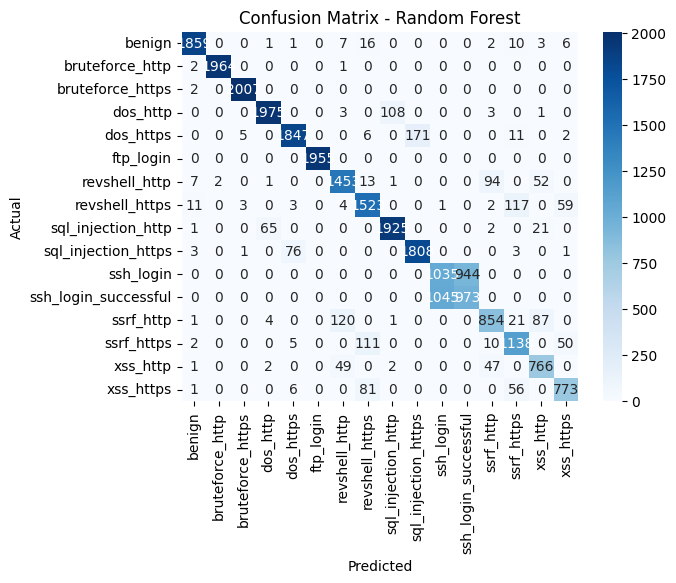

Training Gradient Boosting...

Gradient Boosting Classification Report:
                      precision    recall  f1-score   support

              benign       0.99      0.97      0.98      1905
     bruteforce_http       1.00      1.00      1.00      1967
    bruteforce_https       0.99      1.00      1.00      2009
            dos_http       0.97      0.88      0.92      2090
           dos_https       0.96      0.82      0.88      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.88      0.88      0.88      1623
      revshell_https       0.87      0.86      0.87      1723
  sql_injection_http       0.89      0.96      0.92      2014
 sql_injection_https       0.84      0.96      0.90      1892
           ssh_login       0.50      0.41      0.45      1979
ssh_login_successful       0.51      0.59      0.55      2018
           ssrf_http       0.78      0.84      0.81      1088
          ssrf_https       0.78      0.89      0.83      13

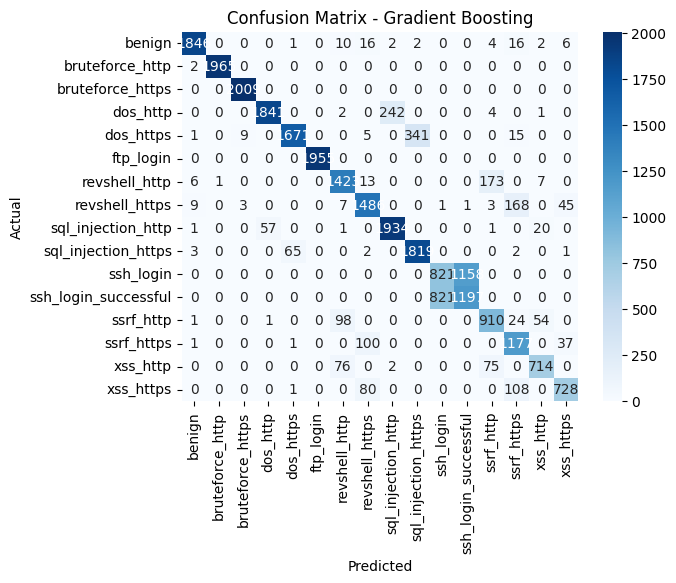

Training Logistic Regression...


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classification Report:
                      precision    recall  f1-score   support

              benign       0.83      0.82      0.82      1905
     bruteforce_http       0.83      1.00      0.90      1967
    bruteforce_https       0.85      0.98      0.91      2009
            dos_http       0.74      0.80      0.77      2090
           dos_https       0.91      0.72      0.80      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.80      0.69      0.74      1623
      revshell_https       0.71      0.65      0.68      1723
  sql_injection_http       0.91      0.89      0.90      2014
 sql_injection_https       0.80      0.95      0.87      1892
           ssh_login       0.00      0.00      0.00      1979
ssh_login_successful       0.50      1.00      0.67      2018
           ssrf_http       0.80      0.61      0.69      1088
          ssrf_https       0.72      0.68      0.70      1316
            xss_http     

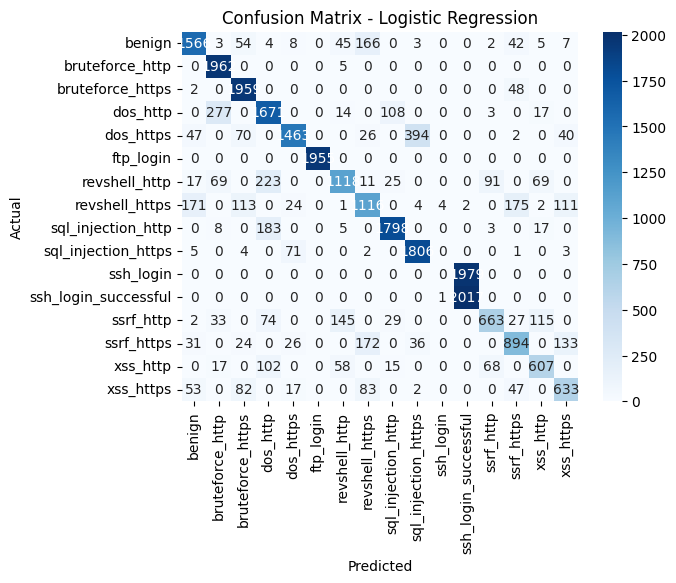

Training SVC linear...

SVC linear Classification Report:
                      precision    recall  f1-score   support

              benign       0.94      0.81      0.87      1905
     bruteforce_http       0.84      1.00      0.91      1967
    bruteforce_https       0.90      1.00      0.95      2009
            dos_http       0.94      0.68      0.79      2090
           dos_https       0.94      0.72      0.82      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.71      0.87      0.78      1623
      revshell_https       0.68      0.82      0.74      1723
  sql_injection_http       0.85      0.98      0.91      2014
 sql_injection_https       0.81      0.95      0.88      1892
           ssh_login       0.49      1.00      0.66      1979
ssh_login_successful       0.00      0.00      0.00      2018
           ssrf_http       0.82      0.61      0.70      1088
          ssrf_https       0.82      0.67      0.73      1316
           

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

Confusion Matrix:


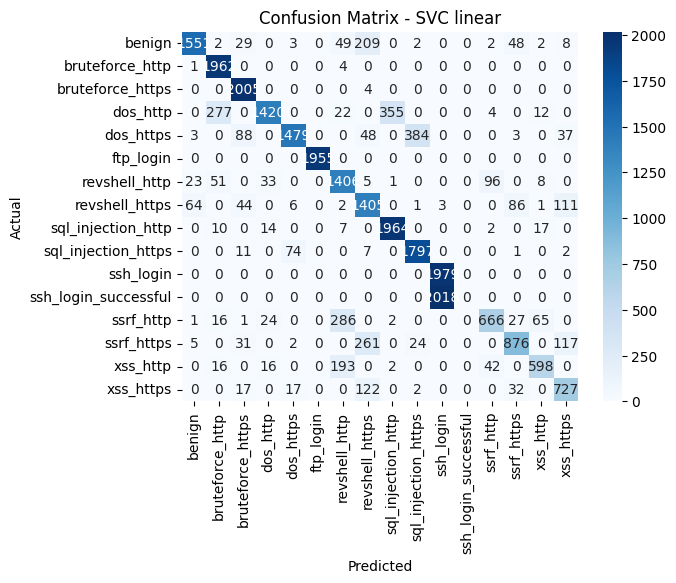

Training SVC RBF...

SVC RBF Classification Report:
                      precision    recall  f1-score   support

              benign       0.98      0.94      0.96      1905
     bruteforce_http       0.82      1.00      0.90      1967
    bruteforce_https       0.90      1.00      0.94      2009
            dos_http       0.87      0.69      0.77      2090
           dos_https       0.93      0.72      0.81      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.89      0.75      0.81      1623
      revshell_https       0.82      0.82      0.82      1723
  sql_injection_http       0.83      0.98      0.90      2014
 sql_injection_https       0.82      0.95      0.88      1892
           ssh_login       0.49      1.00      0.66      1979
ssh_login_successful       0.00      0.00      0.00      2018
           ssrf_http       0.80      0.70      0.75      1088
          ssrf_https       0.76      0.79      0.78      1316
            xss_h

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

Confusion Matrix:


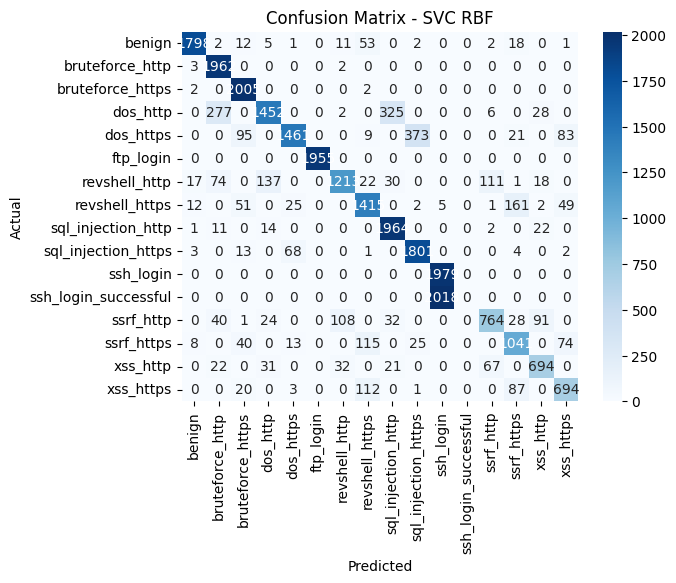

Training SVC Poly...

SVC Poly Classification Report:


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

                      precision    recall  f1-score   support

              benign       0.95      0.92      0.93      1905
     bruteforce_http       0.81      1.00      0.89      1967
    bruteforce_https       0.78      0.98      0.86      2009
            dos_http       0.87      0.69      0.77      2090
           dos_https       0.87      0.64      0.74      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.89      0.69      0.78      1623
      revshell_https       0.75      0.74      0.75      1723
  sql_injection_http       0.75      0.98      0.85      2014
 sql_injection_https       0.69      0.95      0.80      1892
           ssh_login       0.49      1.00      0.66      1979
ssh_login_successful       0.00      0.00      0.00      2018
           ssrf_http       0.84      0.65      0.73      1088
          ssrf_https       0.90      0.67      0.76      1316
            xss_http       0.80      0.72      0.76       867
       

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


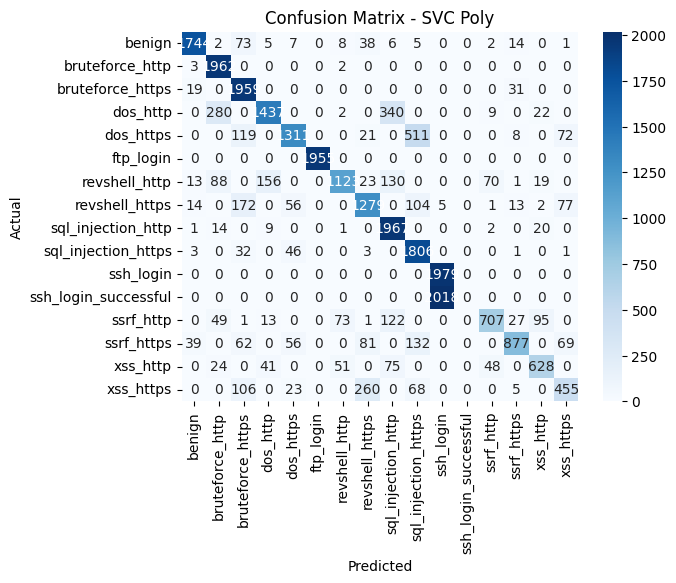

Training K-Neighbors...

K-Neighbors Classification Report:
                      precision    recall  f1-score   support

              benign       0.99      0.96      0.97      1905
     bruteforce_http       1.00      1.00      1.00      1967
    bruteforce_https       1.00      1.00      1.00      2009
            dos_http       0.96      0.93      0.95      2090
           dos_https       0.95      0.90      0.93      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.85      0.86      0.85      1623
      revshell_https       0.82      0.84      0.83      1723
  sql_injection_http       0.95      0.95      0.95      2014
 sql_injection_https       0.94      0.96      0.95      1892
           ssh_login       0.49      0.51      0.50      1979
ssh_login_successful       0.50      0.48      0.49      2018
           ssrf_http       0.76      0.74      0.75      1088
          ssrf_https       0.79      0.83      0.81      1316
         

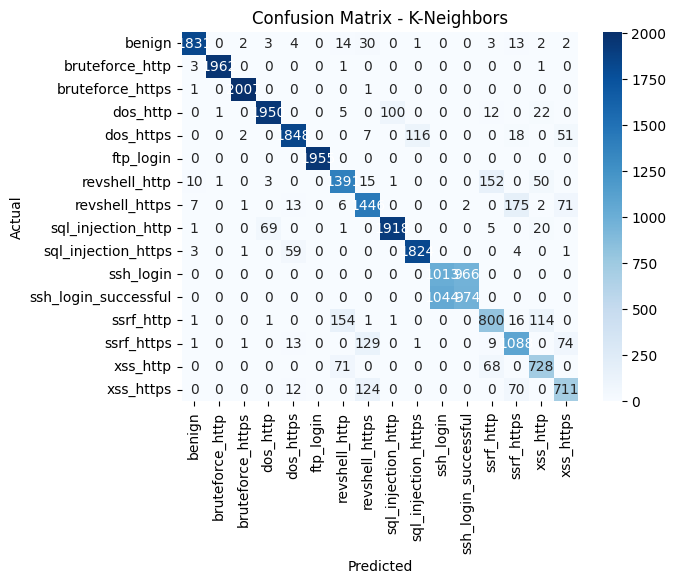

Training Decision Tree...

Decision Tree Classification Report:
                      precision    recall  f1-score   support

              benign       0.98      0.97      0.97      1905
     bruteforce_http       1.00      1.00      1.00      1967
    bruteforce_https       1.00      1.00      1.00      2009
            dos_http       0.96      0.96      0.96      2090
           dos_https       0.95      0.93      0.94      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.87      0.89      0.88      1623
      revshell_https       0.85      0.87      0.86      1723
  sql_injection_http       0.94      0.95      0.95      2014
 sql_injection_https       0.94      0.96      0.95      1892
           ssh_login       0.50      0.54      0.52      1979
ssh_login_successful       0.51      0.47      0.49      2018
           ssrf_http       0.82      0.77      0.79      1088
          ssrf_https       0.84      0.85      0.84      1316
     

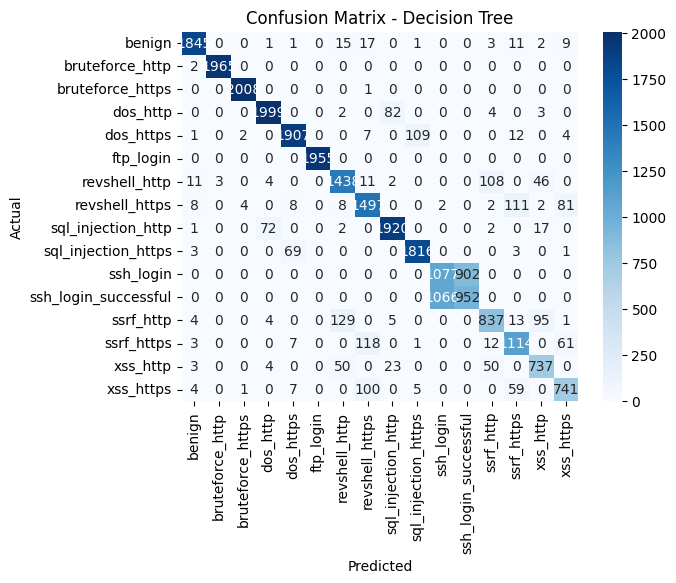

Training AdaBoost...

AdaBoost Classification Report:


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

                      precision    recall  f1-score   support

              benign       0.00      0.00      0.00      1905
     bruteforce_http       0.00      0.00      0.00      1967
    bruteforce_https       0.00      0.00      0.00      2009
            dos_http       0.24      1.00      0.38      2090
           dos_https       0.00      0.00      0.00      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.93      0.46      0.61      1623
      revshell_https       0.15      0.99      0.25      1723
  sql_injection_http       0.00      0.00      0.00      2014
 sql_injection_https       0.00      0.00      0.00      1892
           ssh_login       0.00      0.00      0.00      1979
ssh_login_successful       0.50      1.00      0.67      2018
           ssrf_http       0.00      0.00      0.00      1088
          ssrf_https       0.00      0.00      0.00      1316
            xss_http       0.00      0.00      0.00       867
       

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


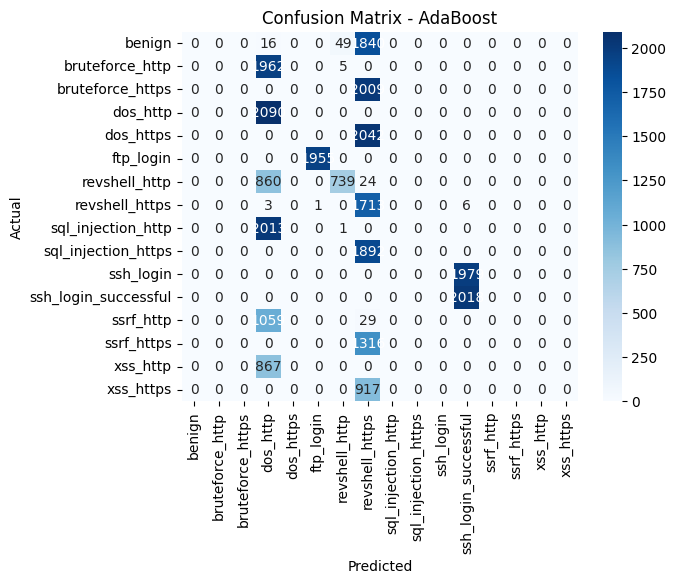

Training Gaussian Naive Bayes...

Gaussian Naive Bayes Classification Report:
                      precision    recall  f1-score   support

              benign       0.34      0.23      0.28      1905
     bruteforce_http       0.59      1.00      0.74      1967
    bruteforce_https       0.93      1.00      0.96      2009
            dos_http       0.42      0.28      0.34      2090
           dos_https       0.76      0.60      0.67      2042
           ftp_login       1.00      1.00      1.00      1955
       revshell_http       0.92      0.44      0.59      1623
      revshell_https       0.62      0.00      0.01      1723
  sql_injection_http       0.75      0.84      0.79      2014
 sql_injection_https       0.64      0.96      0.77      1892
           ssh_login       0.29      0.00      0.00      1979
ssh_login_successful       0.50      1.00      0.67      2018
           ssrf_http       0.96      0.14      0.24      1088
          ssrf_https       0.35      0.59      0.44  

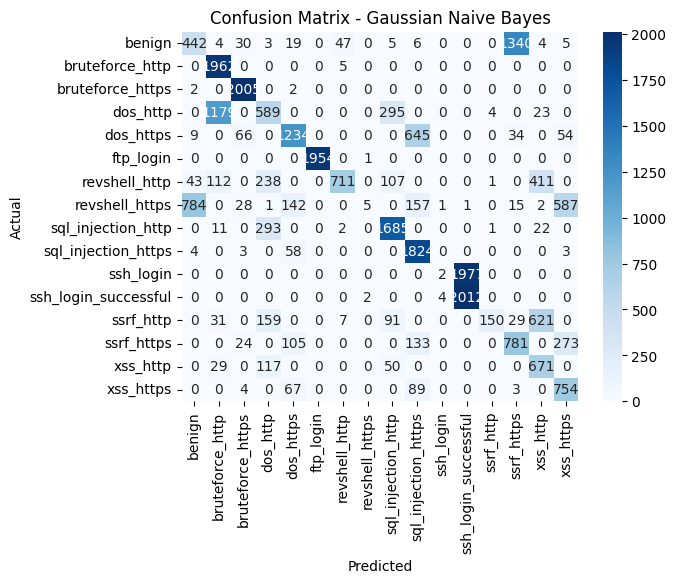

In [114]:
trained_clfs, performace_dict_1 = train_and_evaluate_model(
                    X, 
                    y_attack_type, 
                    top_features=top_features, 
                    classifiers=classifiers)

### Dementionality Reduced data for model training

In [115]:
# x_pca = PCA(n_components=3).fit_transform(X[top_features])
# x_tsne = TSNE(n_components=3, random_state=42).fit_transform(X[top_features])
# x_umap = UMAP(n_components=3, random_state=42).fit_transform(X[top_features])

### Boosting Classifiers Training

Training XGBoost...


e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:26:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1905
           1       1.00      1.00      1.00      1967
           2       1.00      1.00      1.00      2009
           3       0.97      0.92      0.94      2090
           4       0.97      0.85      0.91      2042
           5       1.00      1.00      1.00      1955
           6       0.90      0.88      0.89      1623
           7       0.86      0.89      0.87      1723
           8       0.92      0.96      0.94      2014
           9       0.87      0.97      0.92      1892
          10       0.50      0.49      0.50      1979
          11       0.51      0.53      0.52      2018
          12       0.81      0.80      0.81      1088
          13       0.83      0.87      0.85      1316
          14       0.82      0.88      0.85       867
          15       0.90      0.83      0.86       917

    accuracy                           0.87     

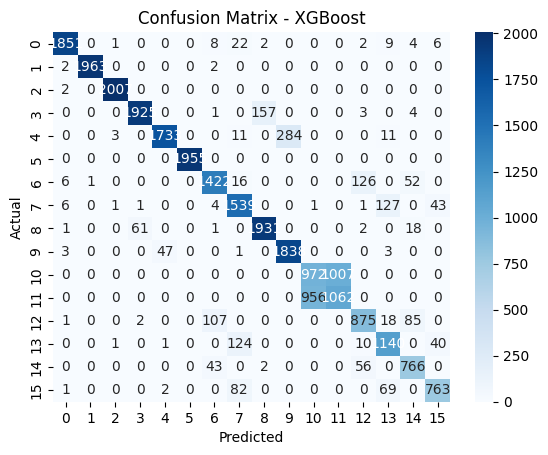

Training CatBoost...

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1905
           1       1.00      1.00      1.00      1967
           2       0.99      1.00      0.99      2009
           3       0.97      0.90      0.93      2090
           4       0.96      0.82      0.88      2042
           5       1.00      1.00      1.00      1955
           6       0.88      0.88      0.88      1623
           7       0.85      0.89      0.87      1723
           8       0.90      0.96      0.93      2014
           9       0.84      0.96      0.90      1892
          10       0.50      0.49      0.49      1979
          11       0.51      0.51      0.51      2018
          12       0.81      0.81      0.81      1088
          13       0.81      0.87      0.84      1316
          14       0.84      0.86      0.85       867
          15       0.90      0.81      0.85       917

    accuracy              

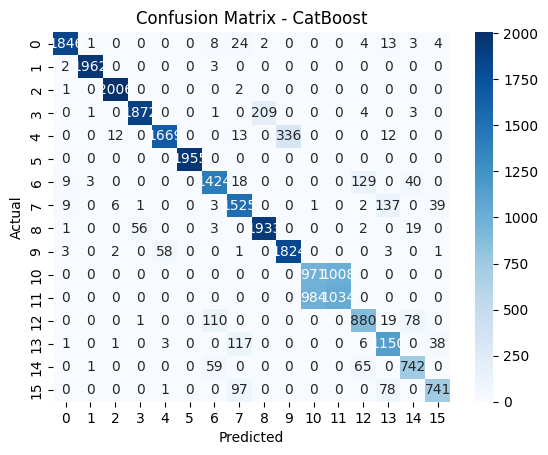

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2739
[LightGBM] [Info] Number of data points in the train set: 109619, number of used features: 15
[LightGBM] [Info] Start training from score -2.689602
[LightGBM] [Info] Start training from score -2.613702
[LightGBM] [Info] Start training from score -2.618695
[LightGBM] [Info] Start training from score -2.631415
[LightGBM] [Info] Start training from score -2.628125
[LightGBM] [Info] Start training from score -2.611960
[LightGBM] [Info] Start training from score -2.855192
[LightGBM] [Info] Start training from score -2.747251
[LightGBM] [Info] Start training from score -2.619947
[LightGBM] [Info] Start training from score -2.604530
[LightGBM] [Info] Start training from score -2.614948
[LightGBM] [Info] Start trainin

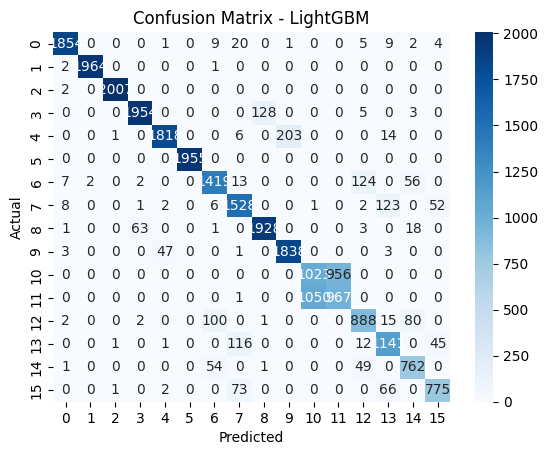

Training AdaBoost...

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1905
           1       0.00      0.00      0.00      1967
           2       0.00      0.00      0.00      2009
           3       0.24      1.00      0.38      2090
           4       0.00      0.00      0.00      2042
           5       1.00      1.00      1.00      1955
           6       0.93      0.46      0.61      1623
           7       0.15      0.99      0.25      1723
           8       0.00      0.00      0.00      2014
           9       0.00      0.00      0.00      1892
          10       0.00      0.00      0.00      1979
          11       0.50      1.00      0.67      2018
          12       0.00      0.00      0.00      1088
          13       0.00      0.00      0.00      1316
          14       0.00      0.00      0.00       867
          15       0.00      0.00      0.00       917

    accuracy              

e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Accadamics\Semesters\Final Year Project\Datasets\Dataset - 12M\dataverse_files\web_ids23_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

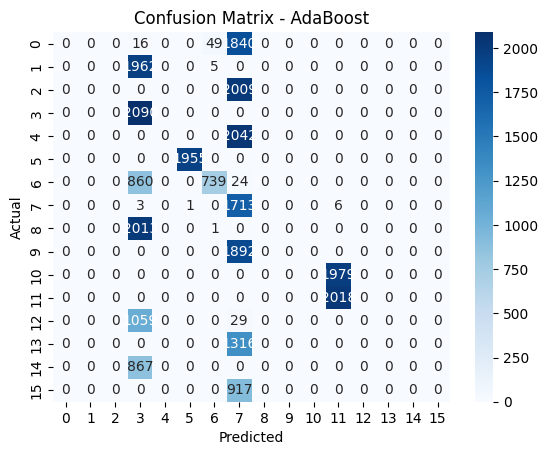

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_attack_type)

trained_xgb_clf, xgb_performance_dict = train_and_evaluate_model(
    X,
    y_encoded,
    top_features=top_features,
    classifiers={
        "XGBoost": XGBClassifier(use_label_encoder=label_encoder, eval_metric='mlogloss'),
        "CatBoost": CatBoostClassifier(verbose=0, random_seed=42),
        "LightGBM": LGBMClassifier(),
        "AdaBoost": AdaBoostClassifier()
    }
)

### K - Nearest Neighbour

In [ ]:
trained_KNN_clf, knn_performance_dict = train_and_evaluate_model(
    X,
    y_attack_type,
    top_features=top_features,
    classifiers={
        "K-Neighbors": KNeighborsClassifier(n_neighbors=5),
    }
)

#### Compare the performance in a list

In [117]:
performace_dict_1.update(xgb_performance_dict)

# Put the performance metrics into a DataFrame for better visualization
performance_df = pd.DataFrame(performace_dict_1).T
performance_df = performance_df.sort_values(by='f1_score', ascending=False)
print("Performance Metrics:")
print(performance_df)

Performance Metrics:
                      accuracy  f1_score  precision    recall
Random Forest         0.870462  0.870435   0.870871  0.870462
Decision Tree         0.868747  0.868585   0.868822  0.868747
XGBoost               0.866338  0.866426   0.867969  0.866338
Gradient Boosting     0.857362  0.856965   0.860323  0.857362
K-Neighbors           0.855537  0.855816   0.856465  0.855537
SVC RBF               0.809998  0.783174   0.776567  0.809998
SVC linear            0.795110  0.768362   0.766764  0.795110
Logistic Regression   0.774603  0.747557   0.738834  0.774603
SVC Poly              0.773180  0.744504   0.745883  0.773180
Gaussian Naive Bayes  0.612334  0.553080   0.627769  0.612334
AdaBoost              0.310710  0.201929   0.190654  0.310710
